In [133]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
import tensorflow as tf

from tqdm import tqdm 
from glob import glob
from skimage.io import imread
from skimage.measure import label, regionprops_table
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.optimizers import Adam
from skimage import io
from keras import backend as K
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from skimage import data, color
from skimage.transform import resize

In [26]:
warnings.filterwarnings('ignore')

In [28]:
def print_evaluate(true, predicted):
    
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def run_all_regressions(X_train, X_test, Y_train, Y_test, regs):

    for name, model in regs.items():

        model.fit(X_train, Y_train)
        
        print(f'\n-----{name}------')
        print('[Train] -------------')
        print_evaluate(Y_train, model.predict(X_train))

        print("\n")
        
        print('[Test] --------------')
        print_evaluate(Y_test, model.predict(X_test))

def extract_props_from_image(mask):
    
    label_image = label(mask)

    feature_names = ['bbox_area',
                     'solidity',
                     'equivalent_diameter', 
                     'orientation',
                     'convex_area', 
                     'area',
                     'extent',
                     'eccentricity',
                     'major_axis_length',
                     'feret_diameter_max',
                     'perimeter',
                     'minor_axis_length']
    
    return pd.DataFrame(regionprops_table(label_image, properties=feature_names))

def labeling_dataset(pd_features, weights_filepath):

    pd_dataset = pd_features.copy()
    
    broilers_weights = pd.read_csv(weights_filepath)

    pd_dataset['target'] = -1

    for anilha, peso in zip(broilers_weights.id,  broilers_weights.weight):

        try: 
            index, *_ = pd_dataset[pd_dataset.label == anilha].index
            pd_dataset.target.iloc[index] = peso
        except:
            continue

    pd_dataset.label.apply(lambda value: value in broilers_weights.id.to_list())

    pd_dataset.drop(pd_dataset[pd_dataset.target < 1].index, inplace=True)

    return pd_dataset

def build_features_dataset(origin_images):
    system_bar = define_barra_path()
    out = pd.DataFrame()

    for path_mask in tqdm(glob(origin_images + f"{system_bar}*")):
        try:
            mask = imread(path_mask)

            props = extract_props_from_image(mask)
            label_name = path_mask.split(system_bar)[-1].split('.')[0]
            props['label'] = int(label_name)

            out = pd.concat([out, props], ignore_index=True)
        
        except Exception as e:
            print("Erro na imagem:", e, end="\n")
            break
            
    return out

def define_barra_path():
    import os
    barra = "/"
    
    if os.name == 'nt':
        barra = "\\"
        
    return barra

def create_dataset(path_images):
    anilhas = []
    paths = []
    anilhas_merged = []
    paths_merged = []

    for index in glob(f"{path_images}/*"):
        anilha, *_ = re.findall(r'\d+', index)
        all_broilers = glob(index + "/**")

        anilhas.append([anilha] * len(all_broilers))
        paths.append(all_broilers)

    for anilha, path in zip(anilhas, paths):
        anilhas_merged = np.concatenate([anilhas_merged, anilha])
        paths_merged = np.concatenate([paths_merged, path])
        
    return anilhas_merged.astype(int), paths_merged

def build_features_dataset_alternative(anilhas, paths, annotation_path):
    out = pd.DataFrame()
    broilers_weights = pd.read_csv(annotation_path)

    for label, path in tqdm(zip(anilhas, paths)):
        mask = imread(path)

        props = extract_props_from_image(mask)
        props['label'] = int(label)

        out = pd.concat([out, props], ignore_index=True)
    
    out['weight'] = -1

    for anilha, peso in zip(broilers_weights.id,  broilers_weights.weight):
        out.weight.iloc[out[out.label == anilha].index] = peso
        
    return out

In [57]:
anilhas, paths = create_dataset("outputs/broilers_with_neck")
features = build_features_dataset_alternative(anilhas, paths, "annotations.csv")

895it [00:17, 49.97it/s]


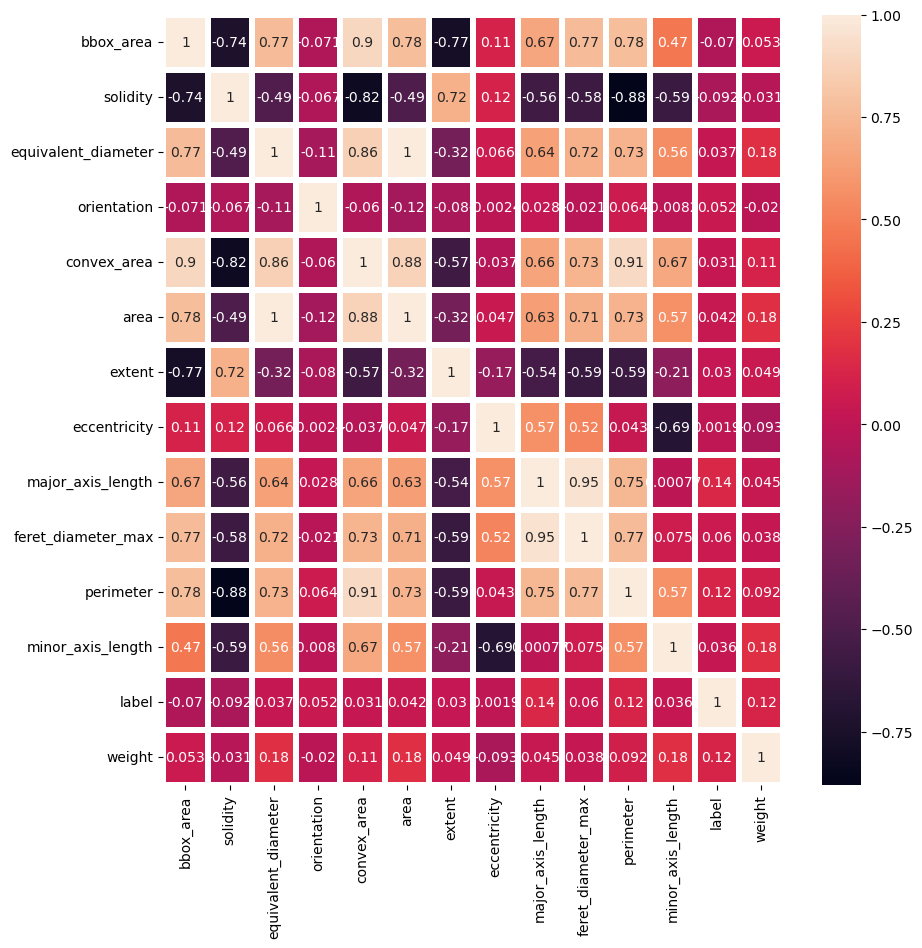

In [58]:
_, ax = plt.subplots(figsize=(10, 10))
corrmat = features.corr()
sns.heatmap(corrmat, linewidths=3, annot=True);

In [69]:
corrmat[corrmat.weight > 0].weight

bbox_area              0.052877
equivalent_diameter    0.178414
convex_area            0.114439
area                   0.182797
extent                 0.048574
major_axis_length      0.044979
feret_diameter_max     0.037718
perimeter              0.091823
minor_axis_length      0.179106
label                  0.119038
weight                 1.000000
Name: weight, dtype: float64

In [73]:
features_names = list(dict(corrmat[corrmat.weight > 0].weight).keys())

try:
    features_names.remove("weight")
    features_names.remove("label")
except:
    print("Key não existe no array")

In [136]:
y = features.weight
X = features[features_names]

X_train, X_test, y_train, y_test = train_test_split(X.values, 
                                                    y.values, 
                                                    test_size=0.3,
                                                    random_state=0)

In [146]:
scaler = StandardScaler()
scaled_x_train, scaled_x_test =  scaler.fit_transform(X_train), scaler.transform(X_test)

In [147]:
run_all_regressions(scaled_x_train, 
                    scaled_x_test,
                    y_train,
                    y_test,
                    regs = {
                        "Random Forest": RandomForestRegressor(n_jobs=-1),
                        "Linear Regression": LinearRegression(),
                        # "L2": Ridge(alpha=.5),
                        # "L1": Lasso(alpha=0.1)
                    })


-----Random Forest------
[Train] -------------
MAE: 59.238178913738025
MSE: 7258.171660063898
RMSE: 85.19490395595207
R2 Square 0.8843444825351596


[Test] --------------
MAE: 175.65513011152416
MSE: 63461.234270260225
RMSE: 251.91513307115994
R2 Square 0.11588187170339592

-----Linear Regression------
[Train] -------------
MAE: 171.82020360952325
MSE: 56804.34094267129
RMSE: 238.33661267768176
R2 Square 0.0948498115411025


[Test] --------------
MAE: 182.22681838861592
MSE: 69180.50372894022
RMSE: 263.0218692978594
R2 Square 0.03620315339328384
